# Simulating Structural Virality
This notebook is a demonstration of how to simulate studies such as [The Structural Virality in Online Diffusion](https://5harad.com/papers/twiral.pdf) by Goel et al. with the simulator (name of which still TBD).

To model this problem, I implemented what I believe to be a generic [Bass Model](https://en.wikipedia.org/wiki/Bass_diffusion_model), which is normally used to study the diffusion of product adoption.
Goel et al. use the Bass model to study the diffusion of "viral" tweets.

## Initialization
The model can be initialized with no parameters, in which case the number of users is chosen randomly.

In [2]:
import rec
import numpy as np

# The Bass model can be initialized with no parameters
bass = rec.BassModel()

Alternatively, the model can be initialized by specifying some parameters, for example the number of agents (_users_). The number of tweets (_items_) can also be specified.

**Note:** the model has only been tested to study the diffusion of one item at a time, so changing the number of items might either yield wrong results or not work at all.

In [3]:
bass = rec.BassModel(num_users=10, num_items=1)
print("Num items", bass.num_items)
print("Num users", bass.num_users)

Num items 1
Num users 10


For more control on the simulation, we can specify our own representations for items and users. In the general case, this has constraints that depend on the model.

Here are the requirements of this Bass model:
- Users must be represented with a `num_users x num_users` binary social graph that defines their connections (u and v are _connected_ if `user_representation[u,v]` is 1).
- Items must be represented with a `1 x num_items` array that defines the probability that each item has to infect other users.
- At the moment, the model only supports `num_items = 1`

In [4]:
# user_representation must be a social graph
# Soon it'll be possible to define this easily with a SocialGraph class, but for now:
num_users, num_items = 5, 1
# Notice that I am only connecting users with themselves (see below for inter-user connections)
user_representation = np.diag(np.diag(np.ones((num_users, num_users))))

# item_representation is an array of probabilities of infection:
# Similarly, this will become a Probability class that can take any distribution. For now:
item_representation = rec.Generator().uniform(size=(1, num_items))

# And now we initialize the new model
bass = rec.BassModel(item_representation=item_representation,
                  user_representation=user_representation)
# As a SocialGraph class has not yet been defined, I need to
# rely on the model's mechanism to connect users:
bass.add_friends(0,4)
bass.add_friends(0,3)
bass.add_friends(1,4)
print("Item attributes \n", bass.item_attributes)
print("User profiles\n", bass.user_profiles)

Item attributes 
 [[0.10741834]]
User profiles
 [[1. 0. 0. 1. 1.]
 [0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 1. 0.]
 [1. 1. 0. 0. 1.]]


In this model, we can also define the initial user who tweeted the tweet. The data structure that represents who tweeted what is called the "infection state." Here we define the _initial_ infection state.

`infection_state` is a `num_users x num_items` binary array that indicates which users have been infected: if u has been infected by item i, then `infection_state[u,i]` is 1.

In [5]:
# (this will also be simplified, but I'm not sure how yet)
infection_state = np.zeros((num_users, num_items))
infection_state[4, np.random.randint(num_items)] = 1
print("Initial infection state\n", bass.infection_state)

Initial infection state
 [[0.]
 [0.]
 [0.]
 [0.]
 [1.]]


Another parameter that we can add is the _infection threshold_, which can be thought of as the probability of a tweet to be retweeted. The infection threshold represents the minimum probability that the user will become infected with items. In other words, if `infection_probability > infection_threshold` for item i and user u, then item i can infect user u.

Currently, the infection threshold is a scalar, but a more realistic view of this would be a `num_users x 1` array (one threshold per user), or even a `num_users x num_items` (one threshold per user per item).

In [6]:
# For the purpose of this tutorial, we ensure that the infection
# threshold is lower than the item infection probabilities:
infection_threshold = np.random.random() % (float(item_representation) - .0000000002)
print("The infection threshold is", infection_threshold)
# Note that the model does not currently support modifying the parameters after initialization.
# So we need to initialize a new model altogether.
bass = rec.BassModel(item_representation=item_representation,
                  user_representation=user_representation,
                  infection_state=np.copy(infection_state), # made a copy to keep infection_state unchanged 
                  infection_threshold=infection_threshold)

The infection threshold is 0.06411171759594675


## Running the model

In the simulation, at each timestep _t_, users look for tweets to retweet from their Twitter feed. If an appealing tweet appears, then they retweet it.

More formally, for each item, item i infects user u if:
- at _t-1_, `user_profiles[u,v] = 1` and
- at _t-1_, `infection_state[v, i] = 1` and
- `infection_state[i] > infection_threshold[u, i]`

In [7]:
# This can be run without parameters, too, in which case timesteps=100 by default
timesteps = 10
bass.run(timesteps=timesteps)

100%|██████████| 10/10 [00:00<00:00, 799.48it/s]


# Evaluation
First of all, we take a look at the infection state. We saved the initial infection state, so we can compare them to see if there is any change.

If there is no change, it could be for a few reasons:
1. The infection threshold is higher than the infection probabilities.
2. The social graph is too sparse and the infected users are isolated.
3. The simulation is too short. This is relevant because, with more infected users in the networks, "healthy" users have a higher chance of being infected.

In [8]:
has_changed = not np.array_equal(bass.infection_state, infection_state)
response = "yes!" if has_changed else "nope."
print("Has the infection state changed?", response)

Has the infection state changed? yes!


## Infection diffusion tree
We print the diffusion tree.

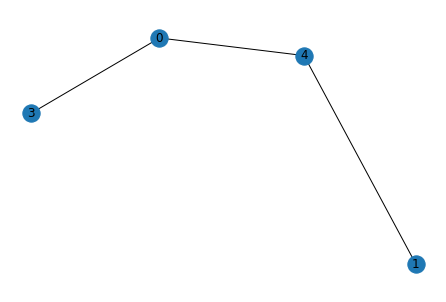

In [9]:
# I currently don't have a "frontend" that plots or draws, except for this wrapper around the networkx.draw() function
# A practical plotting module is also on my TODO list.
# Right now this graph does not really look like a tree, so that will also change with the plotting module.
import matplotlib.pyplot as plt
bass.draw_diffusion_tree()
plt.show()

## Structural virality
Finally, we calculate the structural virality of the diffusion tree. Goel et al. define structural virality as:

> the average distance between all pairs of nodes in a diffusion tree.

This is equal to the average of what is known in the literature as the Wiener index.

In [10]:
# this basically calls networkx.algorithms.wiener.wiener_index() on the graph
# and calculates the average on the number of nodes
bass.get_structural_virality()

0.8333333333333334

## Some more information
By calling the `get_measurements()` method, the data structure returns a dictionary of metrics that are relevant to the model.

By default, the Bass model returns the number of total infected users at each timestep.

In [11]:
# in the future, there will be an easy way to add a new measurement
# measurements and models are already decoupled, so it shouldn't be too complicated
measurements = bass.get_measurements()
# We can easily turn this into a pandas DataFrame
import pandas as pd
df = pd.DataFrame(measurements)
df.set_index('Timesteps')

,# Infected
Timesteps,
0,1
1,3
2,4
3,4
4,4
5,4
6,4
7,4
8,4
